<a href="https://colab.research.google.com/github/Sanjayvaradha/Classification-using-TF-serving/blob/main/tf_serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import subprocess
from sklearn.metrics import multilabel_confusion_matrix


In [ ]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major is 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [ ]:
# print("Installing dependencies for Colab environment")
# !pip install -Uq grpcio==1.26.0
# print('TensorFlow version: {}'.format(tf.__version__))

In [ ]:

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
ds='/content/drive/MyDrive/Plant_Village'

In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS = 3
EPOCHS=30
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory=ds,
    shuffle=True,
    seed=123,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [ ]:
classes=dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
# plt.figure(figsize=(8,8))
# for images,label in dataset.take(2):
#   for i in range(9):
#     plt.subplot(3,3,i+1)
#     #print(images.shape)
#     plt.imshow(images[i].numpy().astype('uint8'))
#     plt.title(classes[label[i]])
#     plt.axis('off')
#     #print(label[0].numpy())

In [ ]:
def partition(dataset,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=1000):
  assert (train_split + test_split + val_split) == 1
  if shuffle:
    dataset=dataset.shuffle(shuffle,seed=10)
  train_size = int(len(dataset)*train_split)
  train = dataset.take(train_size)
  val_size = int(len(dataset)*val_split)
 
  rem= dataset.skip(train_size)
  val = rem.take(val_size)
  test = rem.skip(len(val))
  return train,val,test

In [ ]:
train,val,test=partition(dataset)
print(len(train))
print(len(val))
print(len(test))
train

54
6
8


<TakeDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
train

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
input_shape= (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model = models.Sequential([
                          resize_and_rescale,
                          data_augmentation,
                          layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(64, (3, 3), activation='relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(64, (3, 3), activation='relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Conv2D(64, (3, 3), activation='relu'),
                          layers.MaxPooling2D((2, 2)),
                          layers.Flatten(),
                          layers.Dense(64, activation='relu'),
                          layers.Dense(n_classes, activation='softmax'),
])

In [ ]:
model.build(input_shape)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_3 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(train,epochs=EPOCHS,verbose=1,batch_size=BATCH_SIZE,validation_data=val)

Epoch 1/30
54/54 [==============================] - 18s 218ms/step - loss: 0.8324 - accuracy: 0.5540 - val_loss: 0.8654 - val_accuracy: 0.6510
Epoch 2/30
54/54 [==============================] - 7s 123ms/step - loss: 0.6031 - accuracy: 0.7306 - val_loss: 0.4571 - val_accuracy: 0.8177
Epoch 3/30
54/54 [==============================] - 7s 122ms/step - loss: 0.3607 - accuracy: 0.8492 - val_loss: 0.3126 - val_accuracy: 0.8750
Epoch 4/30
54/54 [==============================] - 7s 122ms/step - loss: 0.2627 - accuracy: 0.8926 - val_loss: 0.3024 - val_accuracy: 0.9010
Epoch 5/30
54/54 [==============================] - 7s 122ms/step - loss: 0.2330 - accuracy: 0.9049 - val_loss: 0.1593 - val_accuracy: 0.9427
Epoch 6/30
54/54 [==============================] - 7s 122ms/step - loss: 0.2687 - accuracy: 0.8944 - val_loss: 0.2580 - val_accuracy: 0.9115
Epoch 7/30
54/54 [==============================] - 7s 123ms/step - loss: 0.2002 - accuracy: 0.9161 - val_loss: 0.1736 - val_accuracy: 0.9375
Epoch

In [ ]:
#model.save('/content/drive/MyDrive/saved_model')

In [ ]:
score=model.evaluate(test)

8/8 [==============================] - 5s 39ms/step - loss: 0.0629 - accuracy: 0.9727


first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


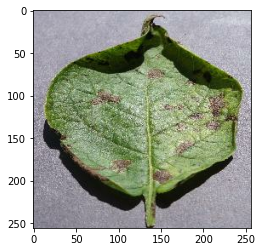

In [ ]:

import numpy as np
for images_batch, labels_batch in test.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])
    

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted, confidence

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


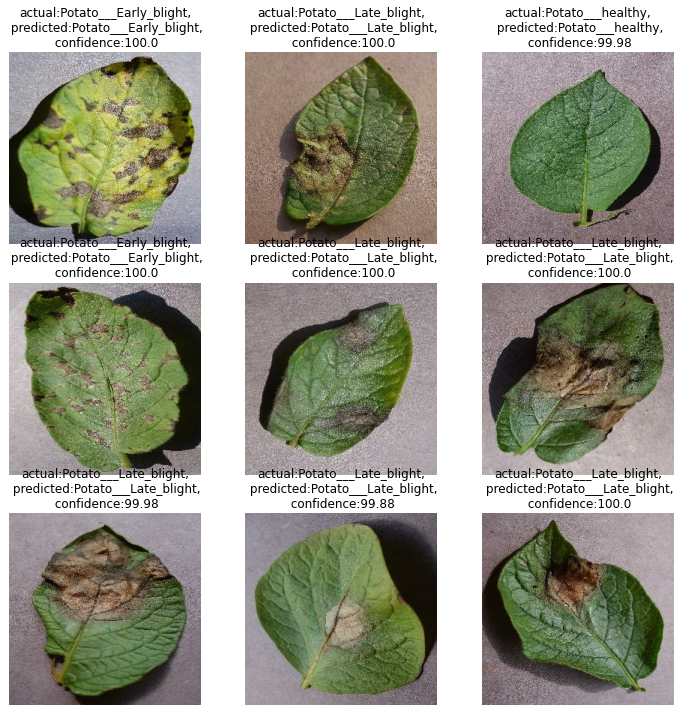

In [ ]:
plt.figure(figsize=(12,12))
for images,label in test.take(3):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    #print(images.shape)
    plt.imshow(images[i].numpy().astype('uint8'))
    actualclass=classes[label[i].numpy()]
    
    prediction, confidence = predict(model, images[i].numpy())
    plt.title(f'actual:{actualclass},\n predicted:{prediction},\n confidence:{confidence}')
    # arr = actualclass.split()
    # pred = prediction.split()
    # confusion=multilabel_confusion_matrix(arr, pred,labels=["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"])
    ax.axis('off')
    
    
    #print(label[0].numpy())

In [ ]:

import tempfile

MODEL_DIR = tempfile.gettempdir()
#MODEL_DIR = '/content/drive/MyDrive/potato_plant_model'
version = '1'
export_path = os.path.join(MODEL_DIR, version)
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)



NameError: ignored

In [ ]:
MODEL_DIR='/content/drive/MyDrive/potato_plant_model'

In [ ]:
print('\nSaved model:')
!ls -l {export_path}


Saved model:
total 692
drwxr-xr-x 2 root root   4096 Sep 15 12:19 assets
-rw-r--r-- 1 root root  39522 Sep 15 13:55 keras_metadata.pb
-rw-r--r-- 1 root root 659010 Sep 15 13:55 saved_model.pb
drwxr-xr-x 2 root root   4096 Sep 15 13:55 variables


In [ ]:
!saved_model_cli show --dir {export_path} --all

Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 990, in main
    args.func(args)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 691, in show
    _show_all(args.dir)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 272, in _show_all
    tag_sets = saved_model_utils.get_saved_model_tag_sets(saved_model_dir)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_utils.py", line 88, in get_saved_model_tag_sets
    saved_model = read_saved_model(saved_model_dir)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_utils.py", line 55, in read_saved_model
    raise IOError("SavedModel file does not exist at: %s" % saved_model_dir)
IOError: SavedModel f

In [ ]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [ ]:

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  28852      0 --:--:-- --:--:-- --:--:-- 28852
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http

In [ ]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 89 not upgraded.
Need to get 347 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.6.0 [347 MB]
Fetched 347 MB in 5s (67.8 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 148492 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.6.0_all.deb ...
Unpacking tensorflow-model-server (2.6.0) ...
Setting up tensorflow-model-server (2.6.0) ...


In [ ]:
import os
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=potato_diseases \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


numpy.ndarray

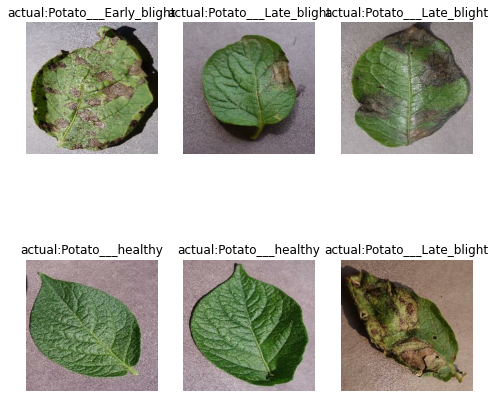

In [ ]:
np.random.seed(11)
plt.figure(figsize=(8,8))
for images,label in test.take(3):
  for i in range(6):
    ax=plt.subplot(2,3,i+1)
    plt.imshow(images.numpy()[i].astype('uint8'))
    actualclass=classes[label[i].numpy()]
    plt.title(f'actual:{actualclass}')
    ax.axis('off')

    x=(images.numpy()[0:6])
    
type(x)


In [ ]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": x.tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 0], [177.0, 155.0, 141.0], [174.0, 152.0, 138.0]]]]}


In [ ]:
def show(predictions):
  plt.figure(figsize=(12,12))
  
  
  for i in range(6):
    
    ax=plt.subplot(2,3,i+1)
    #print(images.shape)
    plt.imshow(x[i].astype('uint8'))
    actualclass=classes[label[i].numpy()]
    
     

    plt.title(f'actual:{actualclass},\n predicted:{classes[np.argmax(predictions[i])]}')
    ax.axis('off')

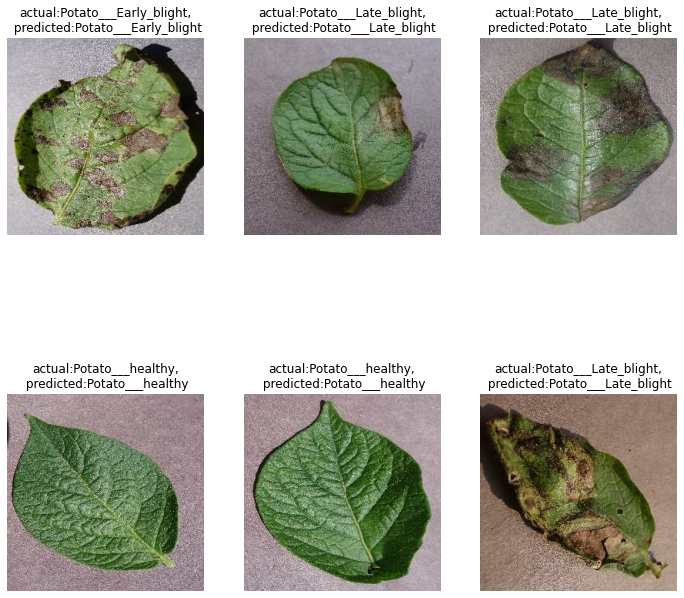

In [ ]:
# docs_infra: no_execute
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/potato_diseases/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(predictions)

